# Evaluation pipeline

## 0 Imports and Constants

In [13]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)

In [14]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import seaborn as sns
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_reg, get_discriminative_test_performance
from data_evaluation.visual.visual_evaluation import visual_evaluation
from predictive_evaluation import predictive_evaluation

In [15]:
DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic" / "usable"

## 1 Load and Visualize Data

### Ways of loading data
- Laden der Originaldaten: als pd dataframe 
- Laden der synthetischen, sequentiellen Daten: als np array (GAN, (V)AE)
- Laden der synthetischen, sequentiellen Daten: als pd dataframe (brownian, algorithmit)

In [16]:
# possible types: 'timegan_lstm', 'timegan_gru', 'jitter', 'timewarp', 'autoencoder'
syn_data_type = 'jitter'

In [17]:
# Load real time series
data_real_df = pd.read_csv(REAL_DATA_FOLDER/'metro_interstate_traffic_volume_label_encoded_no_categorical.csv')
data_real_numpy = dc(data_real_df).to_numpy()

if syn_data_type == 'timegan_lstm':
    # load sequential data (which should already be scaled)
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_lstm_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'timegan_gru':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28499_12_5_gru_unscaled.csv', shape=(28499, 12, 5))

elif syn_data_type == 'autoencoder':
    data_syn_numpy = load_sequential_time_series(SYNTHETIC_DATA_FOLDER/'mitv_28478_12_5_autoencoder_unscaled.csv', shape=(28478, 12, 5))

elif syn_data_type == 'jitter':
    jitter_factor = 0.1
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_jittered_{str(jitter_factor).replace(".", "")}.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

elif syn_data_type == 'timewarp':
    data_syn_df = pd.read_csv(SYNTHETIC_DATA_FOLDER/f'mitv_time_warped.csv')
    data_syn_numpy = dc(data_syn_df).to_numpy()

# Loot at real and syn data
df = pd.DataFrame(data_syn_numpy.reshape(-1, data_syn_numpy.shape[-1]), columns=data_real_df.columns)

print('\n\n syn data:\n')
print(df.describe())

print('\n\nreal data:\n')
print(data_real_df.describe())



 syn data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count    28511.000000  28511.000000  28511.000000  28511.000000  28511.000000
mean      3314.609915    282.697251      0.087762      0.000585     42.550345
std       1979.334229     12.438217      0.677296      0.008304     38.958564
min          0.000000    242.892694      0.000000      0.000000      0.000000
25%       1307.756109    273.430078      0.000000      0.000000      2.276123
50%       3519.132346    284.438376      0.003428      0.000000     37.938644
75%       4957.645301    292.805025      0.052643      0.000568     86.159244
max       7499.889454    310.882360     42.007573      0.510301    107.027592


real data:

       traffic_volume          temp       rain_1h       snow_1h    clouds_all
count     28511.00000  28511.000000  28511.000000  28511.000000  28511.000000
mean       3313.74238    282.688768      0.061611      0.000250     42.122795
std        1971.53206     12.367361 

## 2 Predictive Evaluation

### Set Hyperparameters and Features

In [18]:
hyperparameters = {
    "seq_len": 12,
    "lr": 0.0001,
    "batch_size": 32,
    "hidden_size": 4,
    "num_layers": 1,
    "bidirectional": True,
    "num_evaluation_runs": 10,
    "num_epochs": 200,
    "device": 'cuda' if torch.cuda.is_available() else 'cpu'
}

In [19]:
# evaluate predictive performance
predictive_results = predictive_evaluation(data_real_numpy, data_syn_numpy, hyperparameters, include_baseline=True, verbose=True)

# save results
bidirectionality = "bi" if hyperparameters["bidirectional"] else 'no_bi'
predictive_results.to_csv(DATA_FOLDER / f"results_{syn_data_type}_{hyperparameters['num_epochs']}_{hyperparameters['num_evaluation_runs']}_{bidirectionality}.csv", index=False)

# split in mse and mae results
mse_results = predictive_results.loc[predictive_results['Metric'] == 'MSE']
mae_results = predictive_results.loc[predictive_results['Metric'] == 'MAE']

HYPERPARAMETERS:
seq_len :  12
lr :  0.0001
batch_size :  32
hidden_size :  4
num_layers :  1
bidirectional :  True
num_evaluation_runs :  10
num_epochs :  200
device :  cpu
Synthetic Data is sequential: False
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.28752261228859427
Training Loss: 0.1854680709540844
Training Loss: 0.12445534389466047
Validation Loss: 0.08261483380298935
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07643521847203374
Training Loss: 0.06538191562518478
Training Loss: 0.06016950499266386
Validation Loss: 0.055067581658282974
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05695174803957343
Training Loss: 0.05499038819223642
Training Loss: 0.052534631611779334
Validation Loss: 0.04843473396776767
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04952097405679524
Training Loss: 0.046814492074772715
Training Loss: 0.04359026188962162
Validation Loss: 0.03914914234133249
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.039568011285737156
Training Loss: 0.03652287684381008
Training L

c:\Users\fanny\Documents\ArnesShit\time_series_data_augmentation\data_evaluation\predictive\predictive_evaluation.py:272: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Model': evaluation_method, 'Metric': 'MAE', 'Error': mae}])], ignore_index=True)
 10%|█         | 1/10 [03:18<29:43, 198.21s/it]

Epoch: 1
Training Loss: 0.15495628103613854
Training Loss: 0.12213273383677006
Training Loss: 0.09877034617587924
Validation Loss: 0.08049538568331954
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07372313231229782
Training Loss: 0.0664819497615099
Training Loss: 0.06216474240645766
Validation Loss: 0.05687762110420827
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05886253384873271
Training Loss: 0.057128701582551004
Training Loss: 0.05483518328517675
Validation Loss: 0.0494117879968011
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05159464128315449
Training Loss: 0.0489384476095438
Training Loss: 0.04567189821973443
Validation Loss: 0.03927291197220931
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04072733676061034
Training Loss: 0.03735379579477012
Training Loss: 

 20%|██        | 2/10 [06:46<27:11, 203.94s/it]

Training Loss: 0.004972465115715749
Validation Loss: 0.002188358635097491
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.1940745322406292
Training Loss: 0.13227289017289878
Training Loss: 0.0862227986752987
Validation Loss: 0.057706941337732784
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06371217835694551
Training Loss: 0.06064522657543421
Training Loss: 0.058403863916173575
Validation Loss: 0.05404007531116518
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05578731508925557
Training Loss: 0.05286547901108861
Training Loss: 0.050043666120618585
Validation Loss: 0.04581806618259864
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04668607085011899
Training Loss: 0.0435506584122777
Training Loss: 0.04026949604973197
Validation Loss: 0.03603573359046759
Validation Accurac

 30%|███       | 3/10 [10:06<23:37, 202.51s/it]

Training Loss: 0.005886945165111683
Validation Loss: 0.0029684188736477093
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.0953196388296783
Training Loss: 0.08246859023347497
Training Loss: 0.078268913757056
Validation Loss: 0.07281051718452003
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0747596930526197
Training Loss: 0.0722822828963399
Training Loss: 0.06970207108184695
Validation Loss: 0.06565230281165477
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06674231834709644
Training Loss: 0.06417903168126941
Training Loss: 0.06118680344894528
Validation Loss: 0.0572793393322591
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0575832392834127
Training Loss: 0.05451681397855282
Training Loss: 0.050852467883378265
Validation Loss: 0.046547195361403934
Validation Accuracy: 0

 40%|████      | 4/10 [13:29<20:15, 202.55s/it]

Epoch: 1
Training Loss: 0.06542372593656182
Training Loss: 0.06258560245856643
Training Loss: 0.05917091401293874
Validation Loss: 0.05288114356860686
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.054030203251168134
Training Loss: 0.04985136725008488
Training Loss: 0.04511960215866566
Validation Loss: 0.03805465150750085
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.038574340967461464
Training Loss: 0.03456042620819062
Training Loss: 0.030484174937009813
Validation Loss: 0.025535020642401127
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.02604657342657447
Training Loss: 0.02393741885665804
Training Loss: 0.021500721643678843
Validation Loss: 0.018257585563435312
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.019128870740532874
Training Loss: 0.018263205864932387
Train

 50%|█████     | 5/10 [17:07<17:20, 208.06s/it]

Training Loss: 0.0048770964151481164
Validation Loss: 0.0021876598508201875
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.19643137529492377
Training Loss: 0.15663640450686217
Training Loss: 0.12792626745998859
Validation Loss: 0.09670177545775188
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08777730077505112
Training Loss: 0.07011223701760173
Training Loss: 0.05957278648391366
Validation Loss: 0.0527796150509561
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05401977237313986
Training Loss: 0.051574468668550255
Training Loss: 0.04904362285509706
Validation Loss: 0.045172691491715024
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04573146461509168
Training Loss: 0.0430421432480216
Training Loss: 0.04008921381086111
Validation Loss: 0.03617326299963373
Validation Accur

 60%|██████    | 6/10 [20:37<13:55, 208.77s/it]

Training Loss: 0.00521837507491
Validation Loss: 0.0022282654293969777
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.35176076531410216
Training Loss: 0.2678642651438713
Training Loss: 0.18383611217141152
Validation Loss: 0.08575482658121024
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08410313727334141
Training Loss: 0.06783986382186413
Training Loss: 0.06455492848530411
Validation Loss: 0.05926453615172526
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06145591756328941
Training Loss: 0.05845877191051841
Training Loss: 0.05607350675389171
Validation Loss: 0.051209571426001826
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05277652044780552
Training Loss: 0.049781056586652994
Training Loss: 0.047186809740960595
Validation Loss: 0.042847845828935
Validation Accuracy: 

 70%|███████   | 7/10 [23:55<10:15, 205.26s/it]

Training Loss: 0.005423996794852428
Validation Loss: 0.002417267977751875
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.12444368839263915
Training Loss: 0.09052569519728422
Training Loss: 0.07507808830589056
Validation Loss: 0.06731834890467397
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06772943584248424
Training Loss: 0.06600032825022936
Training Loss: 0.06378868624567985
Validation Loss: 0.0604608403414153
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06152904214337468
Training Loss: 0.05933807805180549
Training Loss: 0.05627585634589195
Validation Loss: 0.05228956022791648
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05276816952042282
Training Loss: 0.049832944246008995
Training Loss: 0.046017773468047384
Validation Loss: 0.041625455084644006
Validation Accur

 80%|████████  | 8/10 [27:13<06:46, 203.04s/it]

Training Loss: 0.005325109597761184
Validation Loss: 0.002522664724095735
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.500240558385849
Training Loss: 0.38453931838274
Training Loss: 0.287994836717844
Validation Loss: 0.19382258931572519
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.15696999609470366
Training Loss: 0.10679705586284399
Training Loss: 0.07840203965082765
Validation Loss: 0.05765669232004144
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05767491780221462
Training Loss: 0.05368366689421236
Training Loss: 0.05168937956914306
Validation Loss: 0.045582755542035856
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04889289491809905
Training Loss: 0.04683995142579079
Training Loss: 0.044743810780346394
Validation Loss: 0.038588689807593154
Validation Accuracy: 0

 90%|█████████ | 9/10 [30:32<03:21, 201.71s/it]

Training Loss: 0.006492804065346718
Validation Loss: 0.0034536488192009455
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5307735542953015
Training Loss: 0.40019709840416906
Training Loss: 0.2930869810283184
Validation Loss: 0.17043325631471162
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.13755475252866745
Training Loss: 0.08102260489016772
Training Loss: 0.06041453991085291
Validation Loss: 0.05117579520250974
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.0535822163335979
Training Loss: 0.051744664199650285
Training Loss: 0.04996254548430443
Validation Loss: 0.046609844970569185
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04821684472262859
Training Loss: 0.04635390617884696
Training Loss: 0.04427208052016795
Validation Loss: 0.041407085431928045
Validation Accura

100%|██████████| 10/10 [33:50<00:00, 200.66s/it]

Training Loss: 0.005925899058347568
Validation Loss: 0.0029892133289864393
Validation Accuracy: 0.0
**************************************************


100%|██████████| 10/10 [33:50<00:00, 203.10s/it]


Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.12664626784622668
Training Loss: 0.08435754466801881
Training Loss: 0.06274207996204495
Validation Loss: 0.05211120657622814
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05006506599485874
Training Loss: 0.045028635868802666
Training Loss: 0.04126709415577352
Validation Loss: 0.03668127718559477
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03599649414420128
Training Loss: 0.031798476502299305
Training Loss: 0.02921817122027278
Validation Loss: 0.02615233790129423
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.026384297702461482
Training Loss: 0.023486262862570585
Training Loss: 0.022180328033864497
Validation Loss: 0.02002671251094408
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.0206630655284971
Training Loss: 0.0186151210218668
Training L

 10%|█         | 1/10 [03:26<30:56, 206.32s/it]

Validation Loss: 0.003840002224105672
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.17966677594929933
Training Loss: 0.12207894667983055
Training Loss: 0.0894216538220644
Validation Loss: 0.07146272329048495
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06557502614334226
Training Loss: 0.05950948534533382
Training Loss: 0.05767288841307163
Validation Loss: 0.05557813091475642
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05447805544361472
Training Loss: 0.0510397900827229
Training Loss: 0.04891711315140128
Validation Loss: 0.04603420936743195
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.044672717079520224
Training Loss: 0.04068862549029291
Training Loss: 0.03796893884427845
Validation Loss: 0.03460537585733312
Validation Accuracy: 0.0
******************************

 20%|██        | 2/10 [06:52<27:29, 206.25s/it]

Validation Loss: 0.0036534127796309466
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10096276473253965
Training Loss: 0.08387043407186866
Training Loss: 0.07794702889397741
Validation Loss: 0.07608099558045354
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07338630329817533
Training Loss: 0.07006403727456928
Training Loss: 0.06822279315441847
Validation Loss: 0.06690230528206638
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06446116037666798
Training Loss: 0.060715272650122644
Training Loss: 0.05812507212162018
Validation Loss: 0.05552104626143916
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.053173121325671674
Training Loss: 0.04869339337572456
Training Loss: 0.04526764920912683
Validation Loss: 0.041549922406589716
Validation Accuracy: 0.0
*************************

 30%|███       | 3/10 [10:18<24:02, 206.02s/it]

Validation Loss: 0.004175956689967156
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.26469119429588317
Training Loss: 0.199500215575099
Training Loss: 0.15015945307910442
Validation Loss: 0.10655723166850846
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.0906767506338656
Training Loss: 0.07324212778359651
Training Loss: 0.06891238441690803
Validation Loss: 0.06724461310365226
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06579543225467205
Training Loss: 0.06260202184319497
Training Loss: 0.06124038763344288
Validation Loss: 0.059723470046111705
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05800386419519782
Training Loss: 0.05418068652972579
Training Loss: 0.05183418712578714
Validation Loss: 0.04945537725233295
Validation Accuracy: 0.0
*******************************

 40%|████      | 4/10 [13:44<20:36, 206.07s/it]

Validation Loss: 0.003367945175157504
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.708885271847248
Training Loss: 0.5143254360556603
Training Loss: 0.35102756224572657
Validation Loss: 0.21008933297871205
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.16164021287113428
Training Loss: 0.10586628559976816
Training Loss: 0.08551053227856756
Validation Loss: 0.07837499759756447
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07492684438824654
Training Loss: 0.07150318251922727
Training Loss: 0.07065715786069632
Validation Loss: 0.07092313742620891
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06897121027112008
Training Loss: 0.06636485148221255
Training Loss: 0.06536127664148808
Validation Loss: 0.06510715397974748
Validation Accuracy: 0.0
********************************

 50%|█████     | 5/10 [17:10<17:10, 206.07s/it]

Validation Loss: 0.0036208772040338495
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.2122770134732127
Training Loss: 0.15938860330730675
Training Loss: 0.12506168773397802
Validation Loss: 0.09853857552653618
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.08713486457243562
Training Loss: 0.07130352046340704
Training Loss: 0.0638692825473845
Validation Loss: 0.05958683227889993
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05759805791079998
Training Loss: 0.05405046103522181
Training Loss: 0.052276693470776084
Validation Loss: 0.050166526076833855
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.048553461628034714
Training Loss: 0.04464994593523443
Training Loss: 0.042029851395636794
Validation Loss: 0.03892183189772153
Validation Accuracy: 0.0
**************************

 60%|██████    | 6/10 [20:36<13:43, 205.96s/it]

Validation Loss: 0.0037772366835924095
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4769776064157486
Training Loss: 0.36713581904768944
Training Loss: 0.2661342754215002
Validation Loss: 0.17157241710451213
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1331455859169364
Training Loss: 0.08463813645765185
Training Loss: 0.06503343252465128
Validation Loss: 0.05805639361732461
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05622027687728405
Training Loss: 0.05299031864851713
Training Loss: 0.05200373883359134
Validation Loss: 0.050873154774308205
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.04963870511390269
Training Loss: 0.04659498621709645
Training Loss: 0.04519354432821274
Validation Loss: 0.04370042919233609
Validation Accuracy: 0.0
******************************

 70%|███████   | 7/10 [24:03<10:18, 206.26s/it]

Validation Loss: 0.0031360802217779075
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.3535968378931284
Training Loss: 0.24975416325032712
Training Loss: 0.1615593433752656
Validation Loss: 0.09741068746517884
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.07876415148377419
Training Loss: 0.061192228719592096
Training Loss: 0.057442109547555444
Validation Loss: 0.05515364923755105
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.054556986503303054
Training Loss: 0.05121924642473459
Training Loss: 0.04965237176045775
Validation Loss: 0.04737153310286865
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.046512690940871834
Training Loss: 0.042947325920686126
Training Loss: 0.04099303971044719
Validation Loss: 0.03845824427860842
Validation Accuracy: 0.0
*************************

 80%|████████  | 8/10 [27:29<06:52, 206.26s/it]

Validation Loss: 0.004032321016597195
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.10086497202515603
Training Loss: 0.08056389072909952
Training Loss: 0.07349459834396839
Validation Loss: 0.07122098932858933
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06887003973126411
Training Loss: 0.0653809410519898
Training Loss: 0.06298400532454253
Validation Loss: 0.06039996145900046
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.057551221381872894
Training Loss: 0.05213872525840998
Training Loss: 0.04782543365843594
Validation Loss: 0.04355871078840802
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0414769780728966
Training Loss: 0.036491174614056945
Training Loss: 0.03340575980953872
Validation Loss: 0.03040123451501131
Validation Accuracy: 0.0
*****************************

 90%|█████████ | 9/10 [30:55<03:26, 206.26s/it]

Validation Loss: 0.003280034874764721
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.39904012888669965
Training Loss: 0.3276575654000044
Training Loss: 0.2712521062046289
Validation Loss: 0.20758329520232222
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1716079096496105
Training Loss: 0.10549099618569016
Training Loss: 0.0735025255382061
Validation Loss: 0.06642241083252966
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06417279588058591
Training Loss: 0.06117707034572959
Training Loss: 0.060246594045311214
Validation Loss: 0.06010211449576897
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05765526259317994
Training Loss: 0.054085397906601426
Training Loss: 0.0521887468546629
Validation Loss: 0.05079338833522261
Validation Accuracy: 0.0
********************************

100%|██████████| 10/10 [34:21<00:00, 206.17s/it]


Validation Loss: 0.0030059284887674234
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)
Shape of the data after splitting into sequences: (28500, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.4703123605251312
Training Loss: 0.38318900734186173
Training Loss: 0.27637910649180414
Validation Loss: 0.16652724067314287
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.1284277615696192
Training Loss: 0.07961108066141605
Training Loss: 0.06286374300718307
Validation Loss: 0.06055650895649797
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05860127674415708
Training Loss: 0.05587656337767839
Training Loss: 0.05504894442856312
Validation Loss: 0.05481233412211531
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.052929240260273215
Training Loss: 0.0500610067229718
Training Loss: 0.04892092619091273
Validation Loss: 0.048019749489141984
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04623296489939094
Training Loss: 0.04318808302283287
Training Loss:

 10%|█         | 1/10 [03:24<30:42, 204.70s/it]

Validation Loss: 0.005649865907093698
Validation Accuracy: 0.0351123595505618
**************************************************
Epoch: 1
Training Loss: 0.11444304995238781
Training Loss: 0.07899835987016558
Training Loss: 0.058462302479892966
Validation Loss: 0.05329822985392608
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05185000595636666
Training Loss: 0.04913542809896171
Training Loss: 0.047161742551252245
Validation Loss: 0.04576793478362346
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.044206860503181816
Training Loss: 0.041020843777805564
Training Loss: 0.038450298961251975
Validation Loss: 0.03627974898920635
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.035000955201685426
Training Loss: 0.032095145229250194
Training Loss: 0.02963041476905346
Validation Loss: 0.02751576653001516
Validation Accuracy: 0.0
*******

 20%|██        | 2/10 [06:49<27:20, 205.03s/it]

Validation Loss: 0.005280932313448676
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.11702269649133086
Training Loss: 0.08827421793714166
Training Loss: 0.06739500537514687
Validation Loss: 0.059473420943269566
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05786743741482496
Training Loss: 0.055048547983169556
Training Loss: 0.05322891902178526
Validation Loss: 0.05189036829083153
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05037292408756912
Training Loss: 0.047190359216183426
Training Loss: 0.044386586444452404
Validation Loss: 0.041580136279376706
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.03991083129309118
Training Loss: 0.036167850559577344
Training Loss: 0.032738774809986354
Validation Loss: 0.02950130891724584
Validation Accuracy: 0.0
**********************

 30%|███       | 3/10 [10:14<23:53, 204.73s/it]

Validation Loss: 0.0056440353477269075
Validation Accuracy: 0.0702247191011236
**************************************************
Epoch: 1
Training Loss: 0.06545104304328561
Training Loss: 0.055115815112367274
Training Loss: 0.05122839855030179
Validation Loss: 0.048016936999609634
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04643490485846996
Training Loss: 0.04239840488880873
Training Loss: 0.0393581061437726
Validation Loss: 0.03587749028013328
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03457271263934672
Training Loss: 0.03103784650564194
Training Loss: 0.027946996660903098
Validation Loss: 0.02504912232770846
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.024358629328198732
Training Loss: 0.022337005455046893
Training Loss: 0.020110636726021768
Validation Loss: 0.018710487150702247
Validation Accuracy: 0.0
*******

 40%|████      | 4/10 [13:39<20:29, 204.84s/it]

Validation Loss: 0.004660248722399721
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.6118052786588669
Training Loss: 0.5053580239415169
Training Loss: 0.3869441255182028
Validation Loss: 0.2861704214402799
Validation Accuracy: 0.3862359550561798
**************************************************
Epoch: 2
Training Loss: 0.21603911377489568
Training Loss: 0.12255043035373092
Training Loss: 0.08105619503185153
Validation Loss: 0.07008984195214979
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.06717589979991317
Training Loss: 0.06274134716019035
Training Loss: 0.06283390721306205
Validation Loss: 0.06025319542275386
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.05944976145401597
Training Loss: 0.05596968927420676
Training Loss: 0.05571950230747461
Validation Loss: 0.05322844514183784
Validation Accuracy: 0.0
******************

 50%|█████     | 5/10 [17:04<17:05, 205.12s/it]

Epoch: 1
Training Loss: 0.1763484126329422
Training Loss: 0.11810347840189933
Training Loss: 0.08210322791710496
Validation Loss: 0.0682890232903569
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06498789727687836
Training Loss: 0.06106404807418585
Training Loss: 0.05988502230495214
Validation Loss: 0.059109846506728216
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.058055263627320525
Training Loss: 0.05550426572561264
Training Loss: 0.05416111281141639
Validation Loss: 0.05254218415514137
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.051318389251828196
Training Loss: 0.048254939839243886
Training Loss: 0.04640112360008061
Validation Loss: 0.04414487214696206
Validation Accuracy: 0.0
**************************************************
Epoch: 5
Training Loss: 0.04291040972806513
Training Loss: 0.03975969079881907
Training Lo

 60%|██████    | 6/10 [20:32<13:43, 205.81s/it]

Validation Loss: 0.004794229589810783
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.07594982240349055
Training Loss: 0.061490286700427534
Training Loss: 0.057155080176889896
Validation Loss: 0.055260010712434735
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.053842358272522685
Training Loss: 0.05039386817254126
Training Loss: 0.04796112276613712
Validation Loss: 0.04452638967444053
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.043017299445346
Training Loss: 0.03883751261048019
Training Loss: 0.03557641639374196
Validation Loss: 0.031506792485211675
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.030391554115340114
Training Loss: 0.02716326847206801
Training Loss: 0.024649432003498076
Validation Loss: 0.02215845591461893
Validation Accuracy: 0.0
************************

 70%|███████   | 7/10 [23:58<10:18, 206.09s/it]

Validation Loss: 0.005010202024759871
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5572982500493526
Training Loss: 0.43562486246228216
Training Loss: 0.3030038050562143
Validation Loss: 0.18193996886021635
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.13099394418299198
Training Loss: 0.07798588285222649
Training Loss: 0.06070597887039184
Validation Loss: 0.05660432581318898
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.054986438918858765
Training Loss: 0.05224168221466243
Training Loss: 0.052721521351486444
Validation Loss: 0.051383216970003726
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.050697799045592545
Training Loss: 0.04808064299635589
Training Loss: 0.047985636172816155
Validation Loss: 0.046003566092152275
Validation Accuracy: 0.0
*************************

 80%|████████  | 8/10 [27:26<06:53, 206.71s/it]

Validation Loss: 0.005162196273109719
Validation Accuracy: 0.05266853932584269
**************************************************
Epoch: 1
Training Loss: 0.3581050138175488
Training Loss: 0.27752638444304467
Training Loss: 0.21078296016901732
Validation Loss: 0.16769038944431905
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.14285311561077832
Training Loss: 0.10934141343459487
Training Loss: 0.08763058714568615
Validation Loss: 0.07860885024740455
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.07375375188887119
Training Loss: 0.06783074241131544
Training Loss: 0.06668703949078918
Validation Loss: 0.06574220352628257
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.06462875021621585
Training Loss: 0.06180477924644947
Training Loss: 0.06163399351760745
Validation Loss: 0.06030125752761123
Validation Accuracy: 0.0
**************

 90%|█████████ | 9/10 [30:53<03:26, 206.77s/it]

Validation Loss: 0.004785503772887914
Validation Accuracy: 0.0175561797752809
**************************************************
Epoch: 1
Training Loss: 0.07990281851962208
Training Loss: 0.07020995907485485
Training Loss: 0.06688902962952853
Validation Loss: 0.06517728369976028
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06329274620860816
Training Loss: 0.059327577017247675
Training Loss: 0.05682459866628051
Validation Loss: 0.053407154893607235
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.05147151958197355
Training Loss: 0.0467776083573699
Training Loss: 0.04316500232554972
Validation Loss: 0.03855469221186437
Validation Accuracy: 0.0
**************************************************
Epoch: 4
Training Loss: 0.0368867854680866
Training Loss: 0.03260997952893376
Training Loss: 0.0290427478402853
Validation Loss: 0.02518220782656683
Validation Accuracy: 0.0
***************

100%|██████████| 10/10 [34:20<00:00, 206.09s/it]


Validation Loss: 0.003866153142645202
Validation Accuracy: 0.0
**************************************************
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (2841, 12, 5)
Shape of the data after splitting into sequences: (2840, 12, 5)
Shape of the data after splitting into sequences: (22797, 12, 5)
Shape of the data after splitting into sequences: (5692, 12, 5)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
Training Loss: 0.06318710377439857
Training Loss: 0.063209009449929
Training Loss: 0.05953276434913277
Training Loss: 0.056192178158089516
Training Loss: 0.05482736431062221
Training Loss: 0.05259345012716949
Training Loss: 0.04933928620070219
Validation Loss: 0.045265644286455735
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04420242674648762
Training Loss: 0.042156511386856436
Training Loss: 0.03684907705523074
Training Loss: 0.03368333291262388
Training Loss: 0.031540073296055196
Training Loss: 0.02969201222527772
Training Loss: 0.02631432964000851
Validation Loss: 0.023817915033395594
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.02363295566290617
Training Loss: 0.022686610659584404
Training Loss: 0.019838016468565912
Training Loss: 0.019647714323364197
Training Loss: 0.019232634645886718
Training Loss: 0.019200064684264363
Training Loss: 0.01710720276925713
Vali

 10%|█         | 1/10 [06:49<1:01:26, 409.57s/it]

Training Loss: 0.0066814375075045975
Validation Loss: 0.004268987038894818
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4369831335544586
Training Loss: 0.3477800339460373
Training Loss: 0.2646255062520504
Training Loss: 0.17808597262948753
Training Loss: 0.10746587948873638
Training Loss: 0.07326262583956122
Training Loss: 0.06436420140787959
Validation Loss: 0.061248681881231316
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.059302481692284345
Training Loss: 0.05978145468980074
Training Loss: 0.05541053269058466
Training Loss: 0.05286178298294544
Training Loss: 0.05172216807492078
Training Loss: 0.05052061092108488
Training Loss: 0.04798957358114422
Validation Loss: 0.045756578264053396
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04392981802113354
Training Loss: 0.042816939326003195
Training Loss: 0.038002627920359376

 20%|██        | 2/10 [13:40<54:40, 410.12s/it]  

Training Loss: 0.005902521377429366
Validation Loss: 0.003264257247683554
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.4381352023780346
Training Loss: 0.36251345202326773
Training Loss: 0.2880085572600365
Training Loss: 0.20305061537772418
Training Loss: 0.13118908893316983
Training Loss: 0.09113779595121742
Training Loss: 0.07388539496809245
Validation Loss: 0.06844924873068985
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06619909539818764
Training Loss: 0.06665716594085097
Training Loss: 0.06329464303329586
Training Loss: 0.0602583977393806
Training Loss: 0.0596383848413825
Training Loss: 0.058231866471469405
Training Loss: 0.05622364981099963
Validation Loss: 0.05344864469342464
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.051926381271332506
Training Loss: 0.05134804289788008
Training Loss: 0.046982106594368814
Tra

 30%|███       | 3/10 [20:29<47:50, 410.01s/it]

Training Loss: 0.005836293834727257
Validation Loss: 0.0031129748646382674
Validation Accuracy: 0.011704119850187267
**************************************************
Epoch: 1
Training Loss: 0.2800711792707443
Training Loss: 0.20136795666068794
Training Loss: 0.12379347695037722
Training Loss: 0.06893409725278615
Training Loss: 0.05657960683107376
Training Loss: 0.05537075974047184
Training Loss: 0.0534383499994874
Validation Loss: 0.052048474899057146
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.050576887261122465
Training Loss: 0.04952197829261422
Training Loss: 0.04570345541462302
Training Loss: 0.04336919747292996
Training Loss: 0.041906467732042076
Training Loss: 0.040167404348030684
Training Loss: 0.036839256063103676
Validation Loss: 0.03481932649256361
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03354698335751891
Training Loss: 0.0318754433747381
Training Loss: 0.

 40%|████      | 4/10 [27:19<40:59, 409.98s/it]

Training Loss: 0.005927846174454316
Validation Loss: 0.0033148011678397265
Validation Accuracy: 0.023408239700374533
**************************************************
Epoch: 1
Training Loss: 0.6481923060119152
Training Loss: 0.476204359382391
Training Loss: 0.309862423017621
Training Loss: 0.17784440767019988
Training Loss: 0.10391251748427749
Training Loss: 0.07189178789034485
Training Loss: 0.055973235946148635
Validation Loss: 0.04949501695369513
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.04733252113685012
Training Loss: 0.046681612320244315
Training Loss: 0.043944958755746485
Training Loss: 0.04225514167919755
Training Loss: 0.04205563818104565
Training Loss: 0.04137411715462804
Training Loss: 0.03965392420068383
Validation Loss: 0.03784135856738921
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.036769404467195274
Training Loss: 0.03641714675351977
Training Loss: 0.033

 50%|█████     | 5/10 [34:09<34:09, 409.81s/it]

Training Loss: 0.005814178256550804
Validation Loss: 0.0033811528635933324
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.15775123864412308
Training Loss: 0.11616452800109983
Training Loss: 0.09064591091126203
Training Loss: 0.07365811716765165
Training Loss: 0.0664799334295094
Training Loss: 0.06383957607671618
Training Loss: 0.061284197457134724
Validation Loss: 0.05808167721838987
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05624604418873787
Training Loss: 0.055282607395201924
Training Loss: 0.050203540129587054
Training Loss: 0.046316765071824195
Training Loss: 0.04409026090987027
Training Loss: 0.04133711330592632
Training Loss: 0.03742708453908563
Validation Loss: 0.034491449496830896
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03310346120037139
Training Loss: 0.031034636301919816
Training Loss: 0.02670532917603

 60%|██████    | 6/10 [40:59<27:19, 409.75s/it]

Training Loss: 0.0058456129161641
Validation Loss: 0.00316175057906797
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.5289059828221798
Training Loss: 0.38693347699940206
Training Loss: 0.2703464062511921
Training Loss: 0.17355948023498058
Training Loss: 0.11010021548718214
Training Loss: 0.07860663555562496
Training Loss: 0.06249728951603174
Validation Loss: 0.05689517403028431
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.054012578912079334
Training Loss: 0.053900099266320466
Training Loss: 0.05038788305595517
Training Loss: 0.04803797300904989
Training Loss: 0.046981103662401436
Training Loss: 0.045646932693198326
Training Loss: 0.04296296734362841
Validation Loss: 0.04139497697576602
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03911276873201132
Training Loss: 0.03789484544657171
Training Loss: 0.03382405919022858
Tra

 70%|███████   | 7/10 [47:48<20:29, 409.71s/it]

Training Loss: 0.006030918518081308
Validation Loss: 0.003476260872191509
Validation Accuracy: 0.0
**************************************************
Epoch: 1
Training Loss: 0.37767056420445444
Training Loss: 0.2859822119027376
Training Loss: 0.20002312202006578
Training Loss: 0.12363538514822721
Training Loss: 0.08171082703396677
Training Loss: 0.06893696285784244
Training Loss: 0.06564632220193743
Validation Loss: 0.06311613912886002
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.06133872440084815
Training Loss: 0.06154692478477955
Training Loss: 0.05806103356182575
Training Loss: 0.05445543984882534
Training Loss: 0.053419127091765405
Training Loss: 0.05112946545705199
Training Loss: 0.048321773260831834
Validation Loss: 0.04520175111399831
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.04343139034695923
Training Loss: 0.04174335829913616
Training Loss: 0.03715117854066193
T

 80%|████████  | 8/10 [54:38<13:39, 409.85s/it]

Training Loss: 0.006413270685588941
Validation Loss: 0.003849176354688847
Validation Accuracy: 0.011704119850187267
**************************************************
Epoch: 1
Training Loss: 0.38378862492740157
Training Loss: 0.2834238474071026
Training Loss: 0.2001482278481126
Training Loss: 0.13276480704545976
Training Loss: 0.08888563301414251
Training Loss: 0.06809054933488369
Training Loss: 0.05804946796968579
Validation Loss: 0.05310013188460793
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.05203403934836388
Training Loss: 0.0524217421002686
Training Loss: 0.04857749616727233
Training Loss: 0.04568847777321935
Training Loss: 0.04446423408575356
Training Loss: 0.04314571144990623
Training Loss: 0.04056737877428532
Validation Loss: 0.0372022929835074
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.03673283723182976
Training Loss: 0.03602449055761099
Training Loss: 0.0319630

 90%|█████████ | 9/10 [1:01:29<06:49, 409.97s/it]

Training Loss: 0.005469904436031356
Validation Loss: 0.003008129265270988
Validation Accuracy: 0.011704119850187267
**************************************************
Epoch: 1
Training Loss: 0.0818753263540566
Training Loss: 0.06632877653464675
Training Loss: 0.05802921498194337
Training Loss: 0.05333798484876752
Training Loss: 0.051475390028208494
Training Loss: 0.04864393661729991
Training Loss: 0.04490551376715302
Validation Loss: 0.04154335367685177
Validation Accuracy: 0.0
**************************************************
Epoch: 2
Training Loss: 0.03956288378685713
Training Loss: 0.03658328821882605
Training Loss: 0.03154793685302138
Training Loss: 0.0285688238684088
Training Loss: 0.026500373343005777
Training Loss: 0.024702954492531716
Training Loss: 0.021533875078894198
Validation Loss: 0.019625767189939594
Validation Accuracy: 0.0
**************************************************
Epoch: 3
Training Loss: 0.01921045661903918
Training Loss: 0.018191944034770133
Training Loss: 0

100%|██████████| 10/10 [1:08:23<00:00, 410.31s/it]

Training Loss: 0.005910302060656249
Validation Loss: 0.003432475085359778
Validation Accuracy: 0.0
**************************************************


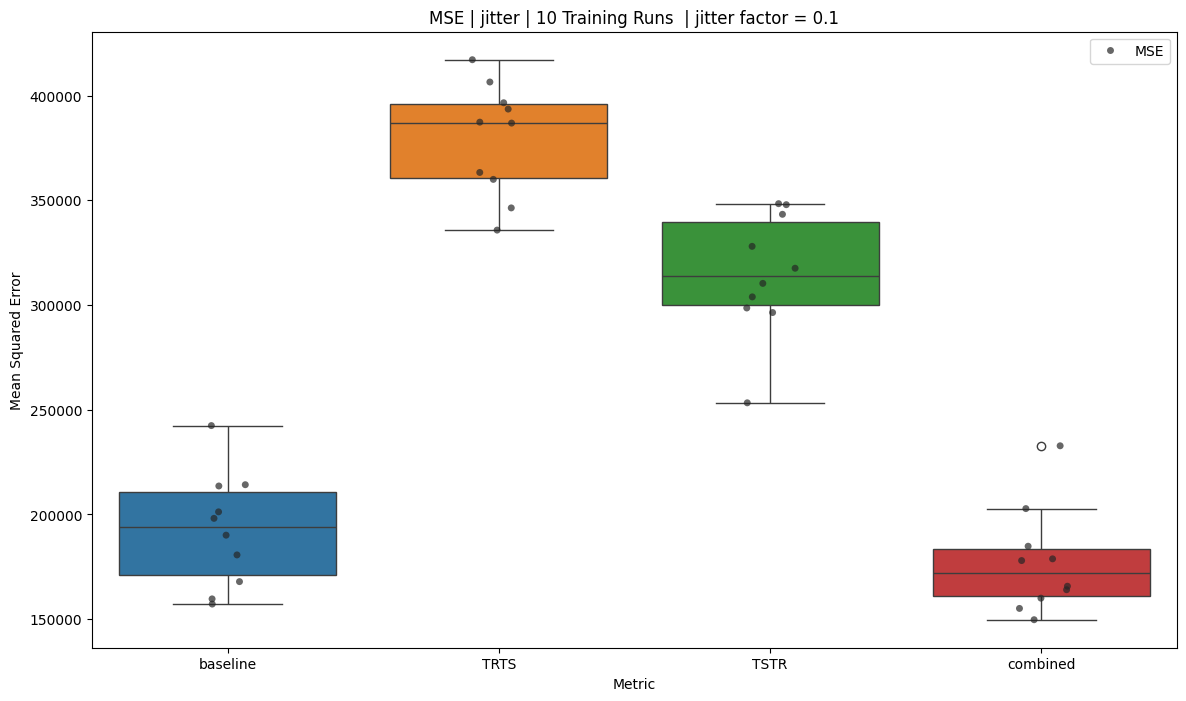

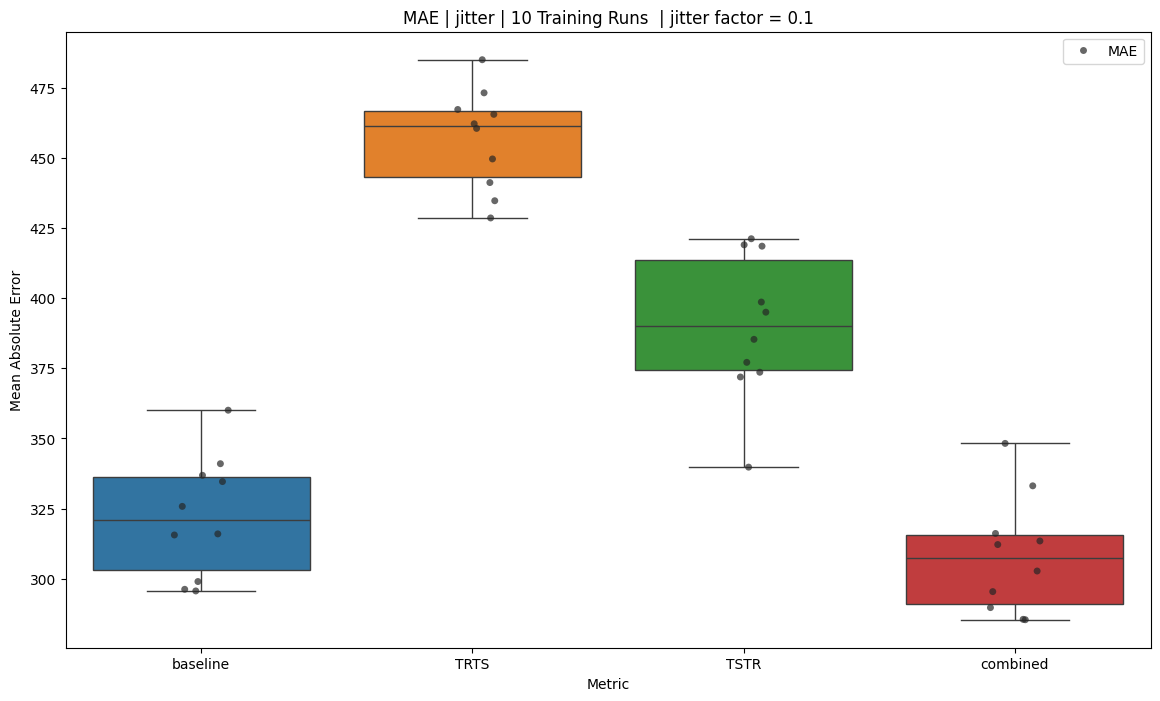

In [20]:
# plot results
plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mse_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mse_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Squared Error')
plt.xlabel('Metric')
plt.title(f'MSE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

plt.figure(figsize=(14, 8))
sns.boxplot(x='Model', y='Error', hue='Model', data=mae_results)
sns.stripplot(x='Model', y='Error', hue='Metric', data=mae_results, dodge=True, jitter=True, palette='dark:black', alpha=0.7)
plt.ylabel('Mean Absolute Error')
plt.xlabel('Metric')
plt.title(f'MAE | {syn_data_type} | {hyperparameters["num_evaluation_runs"]} Training Runs {" | jitter factor = " + str(jitter_factor) if syn_data_type == "jitter" else ""}')
plt.legend()

In [21]:
0.2*1e06

200000.0